In [70]:
import tensorflow as tf
from tensorflow import keras 
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

DIR = 'ObjectDetectionCheckpoint/BackBone/'

AUTOTUNE = tf.data.AUTOTUNE

RES_HEIGHT = 24
RES_WIDTH = 32
NUM_CLASS = 5
N_BATCH =8
N_EPOCH = 60
LR = 0.0005

In [71]:
dataset1_origin = np.load('npz/dataset1_origin.npz', allow_pickle=True)
dataset1_horizon = np.load('npz/dataset1_horizon.npz', allow_pickle=True)
dataset1_vertical = np.load('npz/dataset1_vertical.npz', allow_pickle=True)
dataset1_vh = np.load('npz/dataset1_vh.npz', allow_pickle=True)
dataset2_origin = np.load('npz/dataset2_origin.npz', allow_pickle=True)
dataset2_horizon = np.load('npz/dataset2_horizon.npz', allow_pickle=True)
dataset2_vertical = np.load('npz/dataset2_vertical.npz', allow_pickle=True)
dataset2_vh = np.load('npz/dataset2_vh.npz', allow_pickle=True)

d1o_origin_images, d1o_target_images, d1o_number_labels, d1o_coordinates = dataset1_origin['images'], dataset1_origin['filters'], dataset1_origin['numbers'],  dataset1_origin['coordinates']
d1h_origin_images, d1h_target_images, d1h_number_labels, d1h_coordinates = dataset1_horizon['images'], dataset1_horizon['filters'], dataset1_horizon['numbers'],  dataset1_horizon['coordinates']
d1v_origin_images, d1v_target_images, d1v_number_labels, d1v_coordinates = dataset1_vertical['images'], dataset1_vertical['filters'], dataset1_vertical['numbers'],  dataset1_vertical['coordinates']
d1vh_origin_images, d1vh_target_images, d1vh_number_labels, d1vh_coordinates = dataset1_vh['images'], dataset1_vh['filters'], dataset1_vh['numbers'],  dataset1_vh['coordinates']
d2o_origin_images, d2o_target_images, d2o_number_labels, d2o_coordinates = dataset2_origin['images'], dataset2_origin['filters'], dataset2_origin['numbers'],  dataset2_origin['coordinates']
d2h_origin_images, d2h_target_images, d2h_number_labels, d2h_coordinates = dataset2_horizon['images'], dataset2_horizon['filters'], dataset2_horizon['numbers'],  dataset2_horizon['coordinates']
d2v_origin_images, d2v_target_images, d2v_number_labels, d2v_coordinates = dataset2_vertical['images'], dataset2_vertical['filters'], dataset2_vertical['numbers'],  dataset2_vertical['coordinates']
d2vh_origin_images, d2vh_target_images, d2vh_number_labels, d2vh_coordinates = dataset2_vh['images'], dataset2_vh['filters'], dataset2_vh['numbers'],  dataset2_vh['coordinates']

origin_images = np.concatenate([d1o_origin_images, d2o_origin_images, d1h_origin_images, d2h_origin_images, d1v_origin_images, d2v_origin_images, d1vh_origin_images, d2vh_origin_images], axis = 0)
target_images = np.concatenate([d1o_target_images, d2o_target_images, d1h_target_images, d2h_target_images, d1v_target_images, d2v_target_images, d1vh_target_images, d2vh_target_images], axis = 0)
numbers_labels = np.concatenate([d1o_number_labels, d2o_number_labels, d1h_number_labels, d2h_number_labels, d1v_number_labels, d2v_number_labels, d1vh_number_labels, d2vh_number_labels], axis = 0)
coordinates = np.concatenate([d1o_coordinates, d2o_coordinates, d1h_coordinates, d2h_coordinates, d1v_coordinates, d2v_coordinates, d1vh_coordinates, d2vh_coordinates], axis = 0)

print(origin_images.shape)
print(target_images.shape)
print(numbers_labels.shape)
print(coordinates.shape)


(13276, 24, 32)
(13276, 24, 32)
(13276,)
(13276, 4, 8)


In [72]:
origin_images = origin_images.reshape(13276, 24, 32, 1)
print(origin_images.shape)

(13276, 24, 32, 1)


In [73]:
print(origin_images.max(), origin_images.min())

origin_images = origin_images / origin_images.max()

print(origin_images.max(), origin_images.min())

print(origin_images.shape)

255 0
1.0 0.0
(13276, 24, 32, 1)


In [74]:
def resize_and_pad_image(image, label, min_side=96, max_side=128):
    
    image_shape = tf.cast(tf.shape(image)[:2], dtype = tf.float32)
    ratio = min_side / tf.reduce_min(image_shape)
    if ratio * tf.reduce_max(image_shape) > max_side:
      ratio = max_side / tf.reduce_max(image_shape)

    new_image_shape = ratio * image_shape

    image = tf.image.resize(image, 
                            tf.cast(new_image_shape, dtype=tf.int32), 
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return image, label


In [75]:
from sklearn.model_selection import train_test_split
train_images, val_images, train_labels, val_labels = train_test_split(
    origin_images, numbers_labels, test_size=0.3, random_state=42
)

In [76]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, depth=NUM_CLASS)
    return image, label

In [77]:
train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

In [78]:
train_ds = train_ds.map(resize_and_pad_image)
val_ds = val_ds.map(resize_and_pad_image)

In [79]:
train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)

In [80]:
train_ds = train_ds.shuffle(buffer_size=len(train_images)).batch(N_BATCH).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.batch(N_BATCH).prefetch(buffer_size=AUTOTUNE)

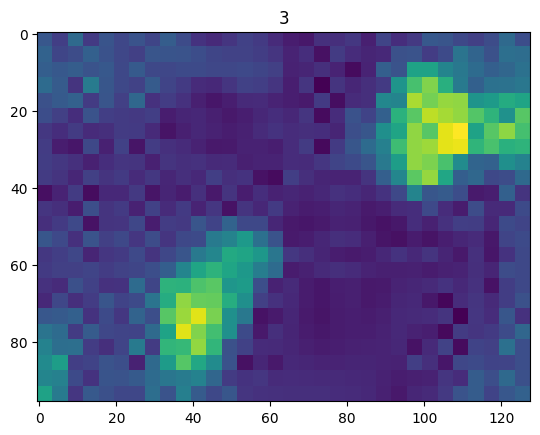

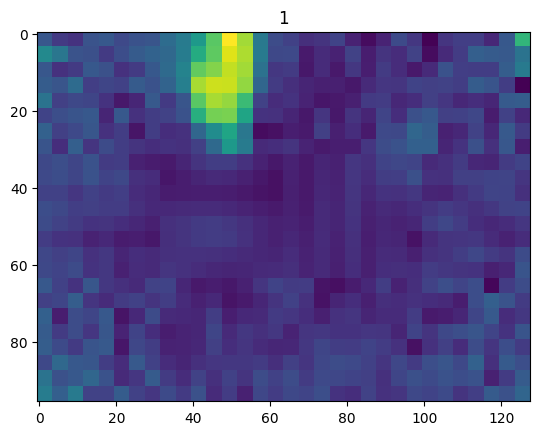

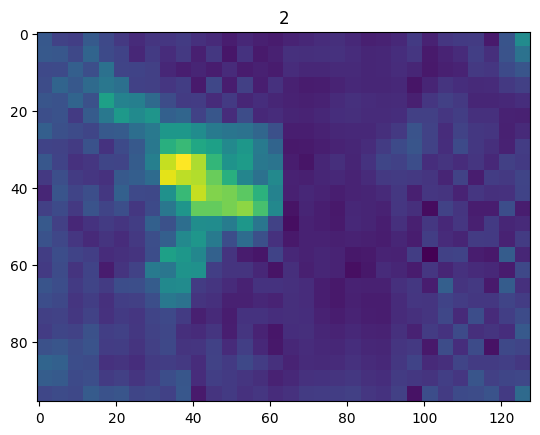

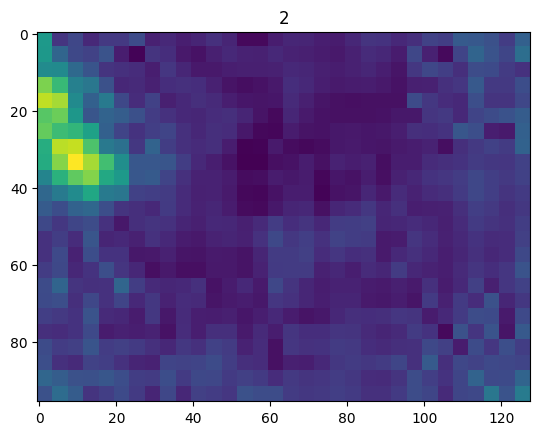

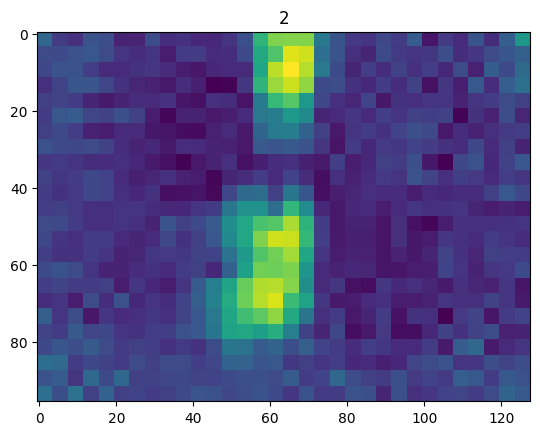

In [81]:
for images, labels in train_ds.take(5):
    plt.imshow(images[0].numpy())
    plt.title(str(labels[0].numpy().argmax()))
    plt.show()

InputLayer 			(None, 24, 32, 1)

UpSampling2D		(None, 72, 96, 1)

----------------------block 1---------------------------

Conv2D 				(None, 72, 96, 3)

BatchNormalization	(None, 72, 96, 3)

ELU					(None, 72, 96, 3)

ZeroPadding2D		(None, 73, 97, 3)

Conv2D				(None, 36, 48, 1)

BatchNormalization	(None, 36, 48, 1) 		block_1_project_BN

<br/>
<br/>

----------------------block 2---------------------------

Conv2D				(None, 36, 48, 3)

BatchNormalization	(None, 36, 48, 3)

ELU					(None, 36, 48, 3)

Conv2D				(None, 36, 48, 1)

BatchNormalization	(None, 36, 48, 1)		block_2_project_BN

Add	(OutPut-1)		(None, 36, 48, 1)		block_1_project_BN + block_2_project_BN 

<br/>
<br/>

----------------------block 3---------------------------

Conv2D				(None, 36, 48, 3)

BatchNormalization	(None, 36, 48, 3)

ELU					(None, 36, 48, 3)

ZeroPadding2D		(None, 37, 49, 3)

Conv2D				(None, 18, 24, 1)

BatchNormalization	(None, 18, 24, 1)		block_3_project_BN

<br/>
<br/>

----------------------block 4---------------------------

Conv2D				(None, 18, 24, 3)

BatchNormalization	(None, 18, 24, 3)

ELU					(None, 18, 24, 3)

Conv2D				(None, 18, 24, 1)

BatchNormalization	(None, 18, 24, 1)		block_4_project_BN

Add	(OutPut-2)		(None, 18, 24, 1)		block_3_project_BN + block_4_project_BN 

<br/>
<br/>

----------------------block 5---------------------------

Conv2D				(None, 18, 24, 3)

BatchNormalization	(None, 18, 24, 3)

ELU					(None, 18, 24, 3)

ZeroPadding2D		(None, 19, 25, 3)

Conv2D				(None, 9, 12, 1)

BatchNormalization	(None, 9, 12, 1)		block_5_project_BN


In [82]:
from keras.layers import Dense, Input, Conv2D, Conv2DTranspose, Flatten, Activation
from keras.layers import Input, GlobalAveragePooling2D, Conv2D, ReLU, Reshape, Multiply
from keras.layers import BatchNormalization, Dropout, ZeroPadding2D
from keras.models import Model
from keras.layers import ZeroPadding2D, DepthwiseConv2D
from keras.regularizers import l2
from keras.layers import Add
import tensorflow as tf

class BackBone(tf.keras.Model):
    def __init__(self):
        super(BackBone, self).__init__()
        # self.l2_regularizer = l2(0.001)

    def squeeze_excite_block(self, input_tensor, ratio=8):
        """ Squeeze and Excitation block """
        channels = input_tensor.shape[-1]

        x = GlobalAveragePooling2D()(input_tensor)
        x = Reshape((1, 1, channels))(x)

        x = Conv2D(channels // ratio, (1, 1), padding='same')(x)
        x = ReLU()(x)
        x = Conv2D(channels, (1, 1), padding='same')(x)
        x = tf.keras.activations.sigmoid(x)
        out = Multiply()([input_tensor, x])
        return out

    def residual_layer(self, feature_map, latent, name:str):
        """ Residual block """
        add_layer = Add(name = name+'_output')([feature_map, latent])
        return add_layer

    def feature_extraction_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        # kernel_regularizer=self.l2_regularizer,
                        name = name+'_1')(feature_map)
        feature_map = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        # kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = DepthwiseConv2D(kernel_size=3, padding = 'same')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        
        # upsample_layer = Conv2DTranspose(filters = 6, kernel_size = 3, strides = (3, 3), padding = 'same')(inputs_image)
        # feature_map = Dropout(0.3)(feature_map)

        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        # kernel_regularizer=self.l2_regularizer,
                        name = name+'_3')(feature_map)
        feature_map = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 2, padding = 'same', 
                        # kernel_regularizer=self.l2_regularizer,
                        name = name+'_4')(feature_map)
        feature_map = BatchNormalization()(feature_map)
        feature_map = Activation('relu')(feature_map)
        feature_map = self.squeeze_excite_block(feature_map)
        return feature_map

    def convolutional_residual_block(self, feature_map, filters_conv1:int, filters_conv2:int, name:str):
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        # kernel_regularizer=self.l2_regularizer,
                        name = name+'_1')(feature_map)
        latent = Conv2D(filters=filters_conv1, kernel_size = 3, strides = 1, padding = 'same', 
                        # kernel_regularizer=self.l2_regularizer,
                        name = name+'_2')(feature_map)
        latent = BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        latent = DepthwiseConv2D(kernel_size=3, padding = 'same')(latent)
        # feature_map = Dropout(0.3)(feature_map)

        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        # kernel_regularizer=self.l2_regularizer,
                        name = name+'_3')(latent)
        latent = Conv2D(filters=filters_conv2, kernel_size = 3, strides = 1, padding = 'same', 
                        # kernel_regularizer=self.l2_regularizer,
                        name = name+'_4')(latent)
        latent = BatchNormalization()(latent)
        latent = Activation('relu')(latent)
        # latent = DepthwiseConv2D(kernel_size=3, padding = 'same')(latent)
        residual_block = self.residual_layer(feature_map, latent, name)
        return residual_block
    
    def __call__(self, input_shape=(96, 128, 1)):
        inputs_image = Input(shape=input_shape)
        
        # inputs_image = ZeroPadding2D(((2, 2),(0, 0)))(inputs_image)
        block_1 = self.feature_extraction_block(inputs_image, 4, 8, 'block_1')
        block_1_output = self.convolutional_residual_block(block_1, 4, 8,'block_2')
        block_2 = self.feature_extraction_block(block_1_output, 4, 8, 'block_3')
        block_2_output = self.convolutional_residual_block(block_2, 4, 8, 'block_4')
        block_3 = self.feature_extraction_block(block_2_output, 4, 8, 'block_5')
        block_3_output = self.convolutional_residual_block(block_3, 4, 8, 'block_6')
        block_4 = self.feature_extraction_block(block_3_output, 4, 8, 'block_7')
        block_4_output = self.convolutional_residual_block(block_4, 4, 8, 'block_8')

        latent = GlobalAveragePooling2D()(block_4_output)
        # latent = Dense(64, activation='relu', dtype='float32')(latent)
        # latent = Dropout(0.2)(latent)
        number_output = Dense(5, activation='softmax', name='number_output', dtype='float32')(latent)

        model = Model(inputs_image, number_output)
        return model

In [83]:
import tensorflow as tf
from keras.metrics import Precision, Recall
from keras.callbacks import ModelCheckpoint

backbone = BackBone()
model = backbone()

initial_learning_rate = LR
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5000,
    decay_rate=0.90,
    staircase=True)

lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-6,
    verbose=1)

# strategy = tf.distribute.MirroredStrategy()
# with strategy.scope():
#     backbone = BackBone()
#     model = backbone()
#     optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy', Precision(), Recall()])
#     checkpoint = ModelCheckpoint('v4_backbone_1_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy', Precision(), Recall()])

checkpoint = ModelCheckpoint('ObjectDetectionCheckpoint/BackBone/backbone_best_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 128, 1)]         0         []                            
                                                                                                  
 block_1_1 (Conv2D)          (None, 96, 128, 4)           40        ['input_4[0][0]']             
                                                                                                  
 block_1_2 (Conv2D)          (None, 96, 128, 4)           148       ['block_1_1[0][0]']           
                                                                                                  
 batch_normalization_50 (Ba  (None, 96, 128, 4)           16        ['block_1_2[0][0]']           
 tchNormalization)                                                                          

In [84]:
# from keras.utils import plot_model

# plot_model(model, to_file='./detection_model.png', show_shapes=True, show_layer_names=True)
# Image(filename='detection_model.png')

In [86]:
from tensorflow.keras.callbacks import TensorBoard

log_dir = DIR
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [87]:
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=N_EPOCH,
    verbose=1,  
    callbacks=[checkpoint, tensorboard_callback]
    # callbacks=[checkpoint, lr_reducer]
)

# tensorboard --logdir=Final/v10_final --bind_all

Epoch 1/60
1162/1162 [==============================] - ETA: 0s - loss: 1.1329 - accuracy: 0.5390 - precision_3: 0.6710 - recall_3: 0.3082
Epoch 1: val_accuracy improved from -inf to 0.39769, saving model to backbone_best_model.h5
1162/1162 [==============================] - 62s 40ms/step - loss: 1.1329 - accuracy: 0.5390 - precision_3: 0.6710 - recall_3: 0.3082 - val_loss: 1.4760 - val_accuracy: 0.3977 - val_precision_3: 0.4079 - val_recall_3: 0.3063
Epoch 2/60
1161/1162 [============================>.] - ETA: 0s - loss: 0.7494 - accuracy: 0.6998 - precision_3: 0.7552 - recall_3: 0.6148
Epoch 2: val_accuracy improved from 0.39769 to 0.78684, saving model to backbone_best_model.h5
1162/1162 [==============================] - 44s 38ms/step - loss: 0.7496 - accuracy: 0.6997 - precision_3: 0.7550 - recall_3: 0.6147 - val_loss: 0.5766 - val_accuracy: 0.7868 - val_precision_3: 0.8398 - val_recall_3: 0.7042
Epoch 3/60
1162/1162 [==============================] - ETA: 0s - loss: 0.6289 - accu

In [ ]:
qq!

In [ ]:
plt.plot(hist.history['loss'], label = 'loss')
plt.plot(hist.history['accuracy'], label = 'accuracy')
plt.plot(hist.history['val_loss'], label = 'val_loss')
plt.plot(hist.history['val_accuracy'], label = 'val_accuracy')
plt.legend(loc = 'upper left')

plt.savefig('conv2dTr.png')

In [ ]:
qq!!   86

In [ ]:
model2.save('./v3_3().h5')

In [ ]:
import tensorflow as tf
from tensorflow_model_optimization.sparsity import keras as sparsity
from tensorflow_model_optimization.sparsity.keras import UpdatePruningStep

# train_dataset, train_number_labels,

# 초기 모델 로드
model = tf.keras.models.load_model('./v4_backbone_1_best_model.h5')

# 프루닝 설정
epochs = 1
batch_size = 128
num_train_samples = sum(1 for _ in val_ds)
end_step = np.ceil(num_train_samples / batch_size).astype(np.int32) * epochs
pruning_params = {
    'pruning_schedule': sparsity.PolynomialDecay(initial_sparsity=0.50,
                                                 final_sparsity=0.80,
                                                 begin_step=0,
                                                 end_step=end_step)
}

# 모델에 프루닝 래퍼 적용
model_for_pruning = sparsity.prune_low_magnitude(model, **pruning_params)

# 프루닝 모델 컴파일 및 훈련
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.categorical_crossentropy,
                          metrics=['accuracy'])

callbacks = [
    UpdatePruningStep()
]

model_for_pruning.fit(val_ds, epochs=epochs, callbacks=callbacks)

# 프루닝 제거 및 최종 모델 저장
final_model = sparsity.strip_pruning(model_for_pruning)
final_model.save('pruned_model.h5')


In [ ]:
final_model.summary()

In [ ]:
batch_size = 1
# train_dataset_tf = tf.data.Dataset.from_tensor_slices(test_dataset)
# train_dataset을 배치로 만듦
# batched_train_dataset = train_dataset_tf.batch(batch_size)

In [ ]:
import tensorflow as tf

# 기존 모델 로드
model = tf.keras.models.load_model('v4_backbone_1_best_model.h5')

# 대표 데이터셋을 준비하는 함수
def representative_data_gen():
    for input_value, _ in val_ds.take(100):  # val_ds의 각 요소는 (data, label) 튜플
        # data 부분만 추출하고 float32 타입으로 캐스팅
        yield [tf.cast(input_value, tf.float32).numpy()]

# 훈련 데이터셋을 로드하고 배치 처리
# 여기서 val_ds는 이미 tf.data.Dataset 형식이고, batch_size는 적절한 값으로 설정해야 합니다.
batched_train_dataset = val_ds.batch(batch_size)
batched_train_dataset = batched_train_dataset.map(lambda x, y: (tf.cast(x, tf.float32), y))  # x는 입력 데이터, y는 레이블

# TFLite 변환기 설정
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

# 모든 연산을 float32로 제한
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

# 입력과 출력을 float32로 설정
converter.inference_input_type = tf.float32
converter.inference_output_type = tf.float32

# 모델을 TFLite 모델로 변환
tflite_quant_model = converter.convert()

# TFLite 모델 저장
with open('quantized_model_v1.tflite', 'wb') as f:
    f.write(tflite_quant_model)
